In [1]:
import arcgis
import geoint

In [2]:
help(geoint)

Help on package geoint:

NAME
    geoint

DESCRIPTION
    # Copyright (C) 2020 Jan Tschada (gisfromscratch@live.de)
    #
    # This program is free software: you can redistribute it and/or modify
    # it under the terms of the GNU Lesser General Public License as published by
    # the Free Software Foundation, either version 3 of the License, or
    # (at your option) any later version.
    #
    # This program is distributed in the hope that it will be useful,
    # but WITHOUT ANY WARRANTY; without even the implied warranty of
    # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    # GNU Lesser General Public License for more details.
    #
    # You should have received a copy of the GNU Lesser General Public License
    # along with this program.  If not, see <https://www.gnu.org/licenses/>.
    #

PACKAGE CONTENTS
    geospatial

FUNCTIONS
    create_bins(spatial_grid, latitudes, longitudes)
        Creates bins using a spatial grid and WGS84 coordinates.
    
 

# Create a rectangular spatial grid (500 km)

In [3]:
spatial_grid=geoint.create_spatial_grid(spacing_meters=5e5)

# Create a spatial aggregation using two point locations (Dessau and Bonn)

In [4]:
# Coordinates tuple (latitude, longitude)
# Coordinates arrays [latitude, ...], [longitude, ...]
dessau_coordinates = (51.83864, 12.24555)
bonn_coordinates = (50.73438, 7.09549)
latitudes = [dessau_coordinates[0], bonn_coordinates[0]]
longitudes = [dessau_coordinates[1], bonn_coordinates[1]]
grid_aggregation = geoint.create_bins(spatial_grid, latitudes, longitudes)

# Convert the spatial aggregation to a featureset

In [5]:
grid_featureset = grid_aggregation.to_featureset()

# Connect to ArcGIS Online anonymously

In [6]:
gis = arcgis.GIS()

# Visualize the spatial aggregation on a map

In [7]:
germany_map = gis.map('Germany')
germany_map.basemap = 'dark-gray-vector'

grid_featureset.sdf.spatial.plot(germany_map,
                                 renderer_type='c',  # for class breaks renderer
                                 method='esriClassifyNaturalBreaks',  # classification algorithm
                                 class_count=5,  # choose the number of classes
                                 col='hitCount',  # numeric column to classify
                                 cmap='coolwarm',  # color map to pick colors from for each class
                                 alpha=0.35  # specify opacity
                                )
germany_map

MapView(layout=Layout(height='400px', width='100%'))

# Use Case: Aggregate and Visualize ACLED events

In [58]:
import os
import pandas

acled_environ_key = 'acled.data.filepath'
if not acled_environ_key in os.environ:
    raise ValueError('Define an environment variable named \'%s\' and set the full qualified filepath to the *.csv file containing the ACLED events!' % (acled_environ_key))
    
acled_filepath = os.environ[acled_environ_key]
acled_data = pandas.read_csv(acled_filepath, encoding='utf_8')
acled_latitude_column = 'latitude'
acled_longitude_column = 'longitude'
if (not acled_latitude_column in acled_data.columns or not acled_longitude_column in acled_data.columns):
    raise ValueError('Latitude and Longitude columns must exists!')

latitudes = acled_data[acled_latitude_column]
longitudes = acled_data[acled_longitude_column]
grid_aggregation = geoint.create_bins(spatial_grid, latitudes, longitudes)
grid_featureset = grid_aggregation.to_featureset()

world_map = gis.map()
world_map.basemap = 'dark-gray-vector'

grid_featureset.sdf.spatial.plot(world_map,
                                 renderer_type='c',  # for class breaks renderer
                                 method='esriClassifyNaturalBreaks',  # classification algorithm
                                 class_count=5,  # choose the number of classes
                                 col='hitCount',  # numeric column to classify
                                 cmap='coolwarm',  # color map to pick colors from for each class
                                 alpha=0.75  # specify opacity
                                )
world_map

MapView(layout=Layout(height='400px', width='100%'))

In [9]:
import tempfile

world_map.take_screenshot(False, False, os.path.join(tempfile.gettempdir(), 'spatial_bin.png'))

## Show class breaks from first layer

Text(0.5,1,'Histogram of hit counts')

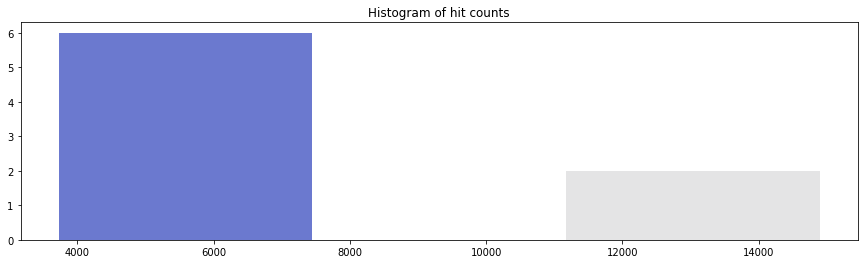

In [68]:
class_breaks = world_map.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
max_values = {}
colors = []
for class_break in class_breaks:
    if class_break.classMaxValue not in max_values:
        max_values[class_break.classMaxValue] = class_break.classMaxValue
        colors.append([color/255.0 for color in class_break.symbol.color])
max_values = list(max_values.values())
    
import matplotlib.pyplot as plt
# build a histogram for the same class breaks
plt.figure(figsize=(15,4))
n, bins, patches = plt.hist(grid_featureset.sdf['hitCount'], bins=max_values)

# apply the same color for each class to match the map
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)
    
plt.title('Histogram of hit counts')